## This is the 2-layer neural network workbook for ECE 239AS Assignment #3

Please follow the notebook linearly to implement a two layer neural network.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and code in the jupyer notebook to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training a two layer neural network.

In [153]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Toy example

Before loading CIFAR-10, there will be a toy example to test your implementation of the forward and backward pass

In [154]:
from nndl.neural_net import TwoLayerNet

In [155]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

### Compute forward pass scores

In [156]:
## Implement the forward pass of the neural network.

# Note, there is a statement if y is None: return scores, which is why 
# the following call will calculate the scores.
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
    [-1.07260209,  0.05083871, -0.87253915],
    [-2.02778743, -0.10832494, -1.52641362],
    [-0.74225908,  0.15259725, -0.39578548],
    [-0.38172726,  0.10835902, -0.17328274],
    [-0.64417314, -0.18886813, -0.41106892]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]

correct scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]

Difference between your scores and correct scores:
3.381231233889892e-08


### Forward pass loss

In [158]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.071696123862817

# should be very small, we get < 1e-12
print("Loss:",loss)
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))


Loss: 1.071696123862817
Difference between your loss and correct loss:
0.0


### Backward pass

Implements the backwards pass of the neural network.  Check your gradients with the gradient check utilities provided.

In [159]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('{} max relative error: {}'.format(param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.2832874456864775e-09
b1 max relative error: 3.1726806716844575e-09
W2 max relative error: 2.9632227682005116e-10
b2 max relative error: 1.8391748601536041e-10


### Training the network

Implement neural_net.train() to train the network via stochastic gradient descent, much like the softmax and SVM.

Final training loss:  0.01455337170351515


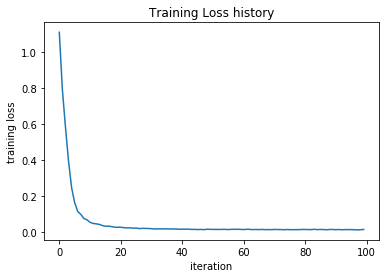

In [160]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

## Classify CIFAR-10

Do classification on the CIFAR-10 dataset.

In [161]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/Users/lixinyi/Desktop/2020 winter ucla/ece 247/HW3-code/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


### Running SGD

If your implementation is correct, you should see a validation accuracy of around 28-29%.

In [220]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = np.mean(net.predict(X_val) == y_val)

print('Validation accuracy: ', val_acc)

# Save this net as the variable subopt_net for later comparison.
subopt_net = net

iteration 0 / 1000: loss 2.302789557349034
iteration 100 / 1000: loss 2.302257093692863
iteration 200 / 1000: loss 2.2950602193755976
iteration 300 / 1000: loss 2.250693215232226
iteration 400 / 1000: loss 2.1980963602738735
iteration 500 / 1000: loss 2.0891719283029135
iteration 600 / 1000: loss 2.119609465147423
iteration 700 / 1000: loss 2.0951781559853724
iteration 800 / 1000: loss 2.0037185947312484
iteration 900 / 1000: loss 2.0050989915114137
Validation accuracy:  0.285


## Questions:

The training accuracy isn't great.  

(1) What are some of the reasons why this is the case?  Take the following cell to do some analyses and then report your answers in the cell following the one below.

(2) How should you fix the problems you identified in (1)?


In [221]:
stats['train_acc_history']

[0.085, 0.22, 0.205, 0.265, 0.285]

blue training acc
orange validation acc


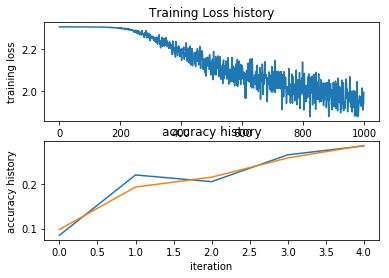

In [222]:
# ================================================================ #
# YOUR CODE HERE:
#   Do some debugging to gain some insight into why the optimization
#   isn't great.
# ================================================================ #

# Plot the loss function and train / validation accuracies


plt.subplot(211)
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')

plt.subplot(212)
plt.plot(stats['train_acc_history'])
plt.plot(stats['val_acc_history'])
plt.xlabel('iteration')
plt.ylabel('accuracy history')
print('blue training acc')
print('orange validation acc')
plt.title('accuracy history')

pass
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

## Answers:

(1) The training loss does not converge at the end(1000 iteration). It wiggles around 1.9. There might have a great chance that the loss end up not being the smallest which means our result is not optimized. 

(2) We can change the leanring rate to see if the results get better. Or change learning rate decay. We can also increase the iteration number since the graph shows that it is still learning. 

## Optimize the neural network

Use the following part of the Jupyter notebook to optimize your hyperparameters on the validation set.  Store your nets as best_net.

In [218]:
best_net = None # store the best model into this 

# ================================================================ #
# YOUR CODE HERE:
#   Optimize over your hyperparameters to arrive at the best neural
#   network.  You should be able to get over 50% validation accuracy.
#   For this part of the notebook, we will give credit based on the
#   accuracy you get.  Your score on this question will be multiplied by:
#      min(floor((X - 28%)) / %22, 1) 
#   where if you get 50% or higher validation accuracy, you get full
#   points.
#
#   Note, you need to use the same network structure (keep hidden_size = 50)!
# ================================================================ #
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

maxi = 0
max_itr = 0
max_rate = 0
import time

for i in range(5,9):
    itr = (i+1) *1000
    for j in range(7,17):
        time_start =time.time()
        lr_rate = (j+1) * 1e-4
        print('the iteration number is ', itr)
        print('the training rate is ', lr_rate)
        stats = net.train(X_train, y_train, X_val, y_val,num_iters=itr, batch_size=200,
                learning_rate=lr_rate, learning_rate_decay=0.95,reg=0.25, verbose=True)
        val_acc = np.mean(net.predict(X_val) == y_val)
        print('Validation accuracy: ', val_acc)
        if val_acc > maxi:
            maxi = val_acc
            max_itr = itr
            max_rate = lr_rate
            best_net = net
            print('the best iteration / training rate comnination is ',max_itr ,' / ',max_rate)
        print('this cycle took time: ',time.time()-time_start)
        print('-------------------------------------------------------------')

print('the best iteration / training rate comnination is ',max_itr ,' / ',max_rate)

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


the iteration number is  6000
the training rate is  0.0008
iteration 0 / 6000: loss 2.3027681216924725
iteration 100 / 6000: loss 2.0031622965955926
iteration 200 / 6000: loss 1.7563570665868824
iteration 300 / 6000: loss 1.7282962192682523
iteration 400 / 6000: loss 1.6270380442671812
iteration 500 / 6000: loss 1.6722746757056377
iteration 600 / 6000: loss 1.6451005245597943
iteration 700 / 6000: loss 1.5643384366013118
iteration 800 / 6000: loss 1.582593171388297
iteration 900 / 6000: loss 1.60720262725992
iteration 1000 / 6000: loss 1.5520212804118354
iteration 1100 / 6000: loss 1.4869651164980662
iteration 1200 / 6000: loss 1.521404649986739
iteration 1300 / 6000: loss 1.3886544696779155
iteration 1400 / 6000: loss 1.5028067119881707
iteration 1500 / 6000: loss 1.490264483337958
iteration 1600 / 6000: loss 1.494227390315677
iteration 1700 / 6000: loss 1.4639885771533916
iteration 1800 / 6000: loss 1.3149974202113495
iteration 1900 / 6000: loss 1.3548075624789295
iteration 2000 / 60

iteration 4500 / 6000: loss 1.292175607732595
iteration 4600 / 6000: loss 1.159161677812286
iteration 4700 / 6000: loss 1.2049172639015093
iteration 4800 / 6000: loss 1.3037741115930361
iteration 4900 / 6000: loss 1.2465385303937355
iteration 5000 / 6000: loss 1.2393699293617
iteration 5100 / 6000: loss 1.112558203236581
iteration 5200 / 6000: loss 1.0918967115269078
iteration 5300 / 6000: loss 1.086223529034014
iteration 5400 / 6000: loss 1.0399407719950893
iteration 5500 / 6000: loss 1.1578089603894663
iteration 5600 / 6000: loss 1.2559158017375145
iteration 5700 / 6000: loss 1.1799602216927942
iteration 5800 / 6000: loss 1.253244352770016
iteration 5900 / 6000: loss 1.2058349608729877
Validation accuracy:  0.521
this cycle took time:  53.6660361289978
-------------------------------------------------------------
the iteration number is  6000
the training rate is  0.0011
iteration 0 / 6000: loss 1.19808680880296
iteration 100 / 6000: loss 1.4208533531995864
iteration 200 / 6000: loss

iteration 2900 / 6000: loss 1.1900678290122821
iteration 3000 / 6000: loss 1.2747091727157789
iteration 3100 / 6000: loss 1.302686033803117
iteration 3200 / 6000: loss 1.2497856504002585
iteration 3300 / 6000: loss 1.2297617359199493
iteration 3400 / 6000: loss 1.2846379368361598
iteration 3500 / 6000: loss 1.2491677186439714
iteration 3600 / 6000: loss 1.2764025184060133
iteration 3700 / 6000: loss 1.1825011963055565
iteration 3800 / 6000: loss 1.2519067656425444
iteration 3900 / 6000: loss 1.1809907037395027
iteration 4000 / 6000: loss 1.1529155323597182
iteration 4100 / 6000: loss 1.255878699618778
iteration 4200 / 6000: loss 1.2276565988656396
iteration 4300 / 6000: loss 1.3926703165767842
iteration 4400 / 6000: loss 1.1623764216215644
iteration 4500 / 6000: loss 1.2158712566064809
iteration 4600 / 6000: loss 1.1545036095411134
iteration 4700 / 6000: loss 1.2199795338270827
iteration 4800 / 6000: loss 1.2000176616175073
iteration 4900 / 6000: loss 1.167286640569292
iteration 5000 /

iteration 1300 / 6000: loss 1.2504481402098215
iteration 1400 / 6000: loss 1.3999790448988592
iteration 1500 / 6000: loss 1.3084378022553889
iteration 1600 / 6000: loss 1.3613370403417007
iteration 1700 / 6000: loss 1.3604477291483008
iteration 1800 / 6000: loss 1.183481778916499
iteration 1900 / 6000: loss 1.2897113604757386
iteration 2000 / 6000: loss 1.3902080603260736
iteration 2100 / 6000: loss 1.250918163398977
iteration 2200 / 6000: loss 1.3352755760402748
iteration 2300 / 6000: loss 1.323191605934058
iteration 2400 / 6000: loss 1.3597908013144175
iteration 2500 / 6000: loss 1.2464151787854982
iteration 2600 / 6000: loss 1.341261487666654
iteration 2700 / 6000: loss 1.2280205080372633
iteration 2800 / 6000: loss 1.275803687554305
iteration 2900 / 6000: loss 1.180614961341147
iteration 3000 / 6000: loss 1.3405652117069673
iteration 3100 / 6000: loss 1.2671598751567905
iteration 3200 / 6000: loss 1.5182637884281274
iteration 3300 / 6000: loss 1.2575427619304824
iteration 3400 / 60

iteration 5900 / 7000: loss 1.0985511416005331
iteration 6000 / 7000: loss 1.1705919151303255
iteration 6100 / 7000: loss 1.2119038157414221
iteration 6200 / 7000: loss 0.9949061625286103
iteration 6300 / 7000: loss 1.1124306228971916
iteration 6400 / 7000: loss 1.1406362323993595
iteration 6500 / 7000: loss 1.136140214743412
iteration 6600 / 7000: loss 1.149507838793261
iteration 6700 / 7000: loss 1.1885553202623775
iteration 6800 / 7000: loss 1.0739269696441611
iteration 6900 / 7000: loss 1.16780040755437
Validation accuracy:  0.513
this cycle took time:  60.81237506866455
-------------------------------------------------------------
the iteration number is  7000
the training rate is  0.0009000000000000001
iteration 0 / 7000: loss 1.0465554057812838
iteration 100 / 7000: loss 1.408594585402481
iteration 200 / 7000: loss 1.2627830491021523
iteration 300 / 7000: loss 1.3746737017162172
iteration 400 / 7000: loss 1.2534037524090447
iteration 500 / 7000: loss 1.2547510610621182
iteration

iteration 1300 / 7000: loss 1.3297336885541826
iteration 1400 / 7000: loss 1.2626819197345927
iteration 1500 / 7000: loss 1.3415308276035096
iteration 1600 / 7000: loss 1.3007449798189015
iteration 1700 / 7000: loss 1.3607836155403934
iteration 1800 / 7000: loss 1.194742474556307
iteration 1900 / 7000: loss 1.1709230480307489
iteration 2000 / 7000: loss 1.2738312976273223
iteration 2100 / 7000: loss 1.2098389872771689
iteration 2200 / 7000: loss 1.4375429353514055
iteration 2300 / 7000: loss 1.2104821453265313
iteration 2400 / 7000: loss 1.1313835820144083
iteration 2500 / 7000: loss 1.3739467614815029
iteration 2600 / 7000: loss 1.2059677660572476
iteration 2700 / 7000: loss 1.3950032554569078
iteration 2800 / 7000: loss 1.217523615735457
iteration 2900 / 7000: loss 1.1997801124431433
iteration 3000 / 7000: loss 1.1837689477112598
iteration 3100 / 7000: loss 1.3665087939614267
iteration 3200 / 7000: loss 1.2266709013481196
iteration 3300 / 7000: loss 1.1710191929800835
iteration 3400 

iteration 4100 / 7000: loss 1.1909544985793086
iteration 4200 / 7000: loss 1.1579387964110945
iteration 4300 / 7000: loss 1.1928240499308922
iteration 4400 / 7000: loss 1.2228713121836559
iteration 4500 / 7000: loss 1.181252021984918
iteration 4600 / 7000: loss 1.1900066318038087
iteration 4700 / 7000: loss 1.1430687800002173
iteration 4800 / 7000: loss 1.2184341165043422
iteration 4900 / 7000: loss 1.1200495807266397
iteration 5000 / 7000: loss 1.2429523797413597
iteration 5100 / 7000: loss 1.129302274877634
iteration 5200 / 7000: loss 1.1826522583253711
iteration 5300 / 7000: loss 1.0256803950503717
iteration 5400 / 7000: loss 1.123623698528133
iteration 5500 / 7000: loss 1.1315322461113901
iteration 5600 / 7000: loss 1.0975669960300527
iteration 5700 / 7000: loss 1.1817390402154524
iteration 5800 / 7000: loss 1.1323901899969475
iteration 5900 / 7000: loss 1.227345176407348
iteration 6000 / 7000: loss 1.2185698230501134
iteration 6100 / 7000: loss 1.1582414625257067
iteration 6200 / 

iteration 6900 / 7000: loss 1.2199609899376451
Validation accuracy:  0.501
this cycle took time:  63.186721086502075
-------------------------------------------------------------
the iteration number is  7000
the training rate is  0.0016
iteration 0 / 7000: loss 1.1664457426791195
iteration 100 / 7000: loss 1.382076346331853
iteration 200 / 7000: loss 1.4167983344305977
iteration 300 / 7000: loss 1.4807221597871258
iteration 400 / 7000: loss 1.6751996345424898
iteration 500 / 7000: loss 1.335472858256287
iteration 600 / 7000: loss 1.442360586308993
iteration 700 / 7000: loss 1.5056861080056907
iteration 800 / 7000: loss 1.4423351338711154
iteration 900 / 7000: loss 1.1870911053327498
iteration 1000 / 7000: loss 1.420717909244241
iteration 1100 / 7000: loss 1.3506047840758804
iteration 1200 / 7000: loss 1.1896446852256715
iteration 1300 / 7000: loss 1.390782809677949
iteration 1400 / 7000: loss 1.2860878829419733
iteration 1500 / 7000: loss 1.272061662305591
iteration 1600 / 7000: loss 

iteration 2300 / 8000: loss 1.3082128874660777
iteration 2400 / 8000: loss 1.1394764241431727
iteration 2500 / 8000: loss 1.1290485041339644
iteration 2600 / 8000: loss 1.1411645670881536
iteration 2700 / 8000: loss 1.1082878767164506
iteration 2800 / 8000: loss 1.3493921653185403
iteration 2900 / 8000: loss 1.183407553933466
iteration 3000 / 8000: loss 1.1495614032441472
iteration 3100 / 8000: loss 1.262960957973604
iteration 3200 / 8000: loss 1.1259679775948523
iteration 3300 / 8000: loss 1.0876210966713524
iteration 3400 / 8000: loss 1.2048611486901437
iteration 3500 / 8000: loss 1.139824168544087
iteration 3600 / 8000: loss 1.195327908538034
iteration 3700 / 8000: loss 1.268204624185969
iteration 3800 / 8000: loss 1.1548102691907083
iteration 3900 / 8000: loss 1.0905297417921938
iteration 4000 / 8000: loss 1.1229872753974792
iteration 4100 / 8000: loss 1.1091272137375874
iteration 4200 / 8000: loss 1.2231190537198142
iteration 4300 / 8000: loss 1.126252157228803
iteration 4400 / 80

iteration 3100 / 8000: loss 1.1269783945118292
iteration 3200 / 8000: loss 1.306958265299265
iteration 3300 / 8000: loss 1.1006832533365252
iteration 3400 / 8000: loss 1.2220586537962406
iteration 3500 / 8000: loss 1.2916075416354054
iteration 3600 / 8000: loss 1.1762519511758138
iteration 3700 / 8000: loss 1.1406556759637638
iteration 3800 / 8000: loss 1.3592355628978465
iteration 3900 / 8000: loss 1.1095182360331735
iteration 4000 / 8000: loss 1.1539648534842306
iteration 4100 / 8000: loss 1.1557353393632332
iteration 4200 / 8000: loss 1.2404274981270593
iteration 4300 / 8000: loss 1.153252281313204
iteration 4400 / 8000: loss 1.161243719339351
iteration 4500 / 8000: loss 1.1923679582675653
iteration 4600 / 8000: loss 1.167296117259139
iteration 4700 / 8000: loss 1.1670278645844456
iteration 4800 / 8000: loss 1.2513327781949422
iteration 4900 / 8000: loss 1.1392760289476629
iteration 5000 / 8000: loss 1.286666723848869
iteration 5100 / 8000: loss 1.1116450535739912
iteration 5200 / 8

iteration 3900 / 8000: loss 1.205268581938903
iteration 4000 / 8000: loss 1.2763611961127903
iteration 4100 / 8000: loss 1.1494141209956334
iteration 4200 / 8000: loss 1.164236543382065
iteration 4300 / 8000: loss 1.196171899509794
iteration 4400 / 8000: loss 1.3370685631424162
iteration 4500 / 8000: loss 1.2934282489065252
iteration 4600 / 8000: loss 1.1182157775759336
iteration 4700 / 8000: loss 1.106569869571494
iteration 4800 / 8000: loss 1.2060159470778569
iteration 4900 / 8000: loss 1.1396490723426964
iteration 5000 / 8000: loss 1.3382001532510936
iteration 5100 / 8000: loss 1.2057614150197533
iteration 5200 / 8000: loss 1.1405367830083275
iteration 5300 / 8000: loss 1.2369975289549353
iteration 5400 / 8000: loss 1.3426595653382656
iteration 5500 / 8000: loss 1.0351845116644314
iteration 5600 / 8000: loss 1.2237278834780112
iteration 5700 / 8000: loss 1.1799242574742752
iteration 5800 / 8000: loss 1.0588144833231885
iteration 5900 / 8000: loss 1.1247935804775726
iteration 6000 / 

iteration 4700 / 8000: loss 1.2219410786611429
iteration 4800 / 8000: loss 1.2452862864147396
iteration 4900 / 8000: loss 1.2298419550989808
iteration 5000 / 8000: loss 1.1257848662274068
iteration 5100 / 8000: loss 1.2300787972401963
iteration 5200 / 8000: loss 1.2234594873606888
iteration 5300 / 8000: loss 1.2507928210303323
iteration 5400 / 8000: loss 1.1788979985320636
iteration 5500 / 8000: loss 1.2418775587875277
iteration 5600 / 8000: loss 1.2496924391473152
iteration 5700 / 8000: loss 1.2631371615987477
iteration 5800 / 8000: loss 1.1140551216365666
iteration 5900 / 8000: loss 1.167844444870084
iteration 6000 / 8000: loss 1.1221908668748837
iteration 6100 / 8000: loss 1.1960525937211521
iteration 6200 / 8000: loss 1.1384940127641292
iteration 6300 / 8000: loss 1.1722084080208162
iteration 6400 / 8000: loss 1.1706696304542532
iteration 6500 / 8000: loss 1.2240717493578956
iteration 6600 / 8000: loss 1.2634355588912594
iteration 6700 / 8000: loss 1.1598675718291902
iteration 6800

iteration 5500 / 8000: loss 1.3055023766643332
iteration 5600 / 8000: loss 1.2969233491822898
iteration 5700 / 8000: loss 1.2762956756433934
iteration 5800 / 8000: loss 1.080183230162567
iteration 5900 / 8000: loss 1.172663284657088
iteration 6000 / 8000: loss 1.2723131869612039
iteration 6100 / 8000: loss 1.2474080342071536
iteration 6200 / 8000: loss 1.175366778895384
iteration 6300 / 8000: loss 1.3691534247274655
iteration 6400 / 8000: loss 1.249698578434235
iteration 6500 / 8000: loss 1.2052903216827058
iteration 6600 / 8000: loss 1.1468295044825236
iteration 6700 / 8000: loss 1.1407683046145298
iteration 6800 / 8000: loss 1.0299017137131918
iteration 6900 / 8000: loss 1.2004378833819236
iteration 7000 / 8000: loss 1.1222071090663093
iteration 7100 / 8000: loss 1.1166234347296857
iteration 7200 / 8000: loss 1.1114308662479262
iteration 7300 / 8000: loss 1.1226687925538579
iteration 7400 / 8000: loss 1.1697148310110592
iteration 7500 / 8000: loss 1.1650313228909468
iteration 7600 / 

iteration 6300 / 9000: loss 1.1751143066210645
iteration 6400 / 9000: loss 1.1843705289548727
iteration 6500 / 9000: loss 1.222596321225069
iteration 6600 / 9000: loss 1.165988356187918
iteration 6700 / 9000: loss 1.200935591123125
iteration 6800 / 9000: loss 1.0972624986218285
iteration 6900 / 9000: loss 1.1956045791080205
iteration 7000 / 9000: loss 1.1145096974011475
iteration 7100 / 9000: loss 1.2248751660721957
iteration 7200 / 9000: loss 1.2011909432710586
iteration 7300 / 9000: loss 1.2665756531487746
iteration 7400 / 9000: loss 1.092025214034682
iteration 7500 / 9000: loss 1.183978432497536
iteration 7600 / 9000: loss 0.956782035616879
iteration 7700 / 9000: loss 1.0658646777480292
iteration 7800 / 9000: loss 1.1144532429964726
iteration 7900 / 9000: loss 1.1052764360140461
iteration 8000 / 9000: loss 1.1797839094039342
iteration 8100 / 9000: loss 1.0546846346522811
iteration 8200 / 9000: loss 1.1655191551245037
iteration 8300 / 9000: loss 1.1400654030723403
iteration 8400 / 90

iteration 4900 / 9000: loss 1.1886388802632886
iteration 5000 / 9000: loss 1.1586502434685
iteration 5100 / 9000: loss 1.2131362972454391
iteration 5200 / 9000: loss 1.3350062549622672
iteration 5300 / 9000: loss 1.2028766566456979
iteration 5400 / 9000: loss 1.2091590337481353
iteration 5500 / 9000: loss 1.2046091037668047
iteration 5600 / 9000: loss 1.2674627692057991
iteration 5700 / 9000: loss 1.0865878708577061
iteration 5800 / 9000: loss 1.0917087038541615
iteration 5900 / 9000: loss 1.0764427408474173
iteration 6000 / 9000: loss 1.14399962460919
iteration 6100 / 9000: loss 1.0263267788756276
iteration 6200 / 9000: loss 1.0969415677285888
iteration 6300 / 9000: loss 1.2263547883698753
iteration 6400 / 9000: loss 1.1752894023619076
iteration 6500 / 9000: loss 1.0103997833085843
iteration 6600 / 9000: loss 1.1226879809552586
iteration 6700 / 9000: loss 1.1422943968870594
iteration 6800 / 9000: loss 1.2317252679183162
iteration 6900 / 9000: loss 1.103162536238566
iteration 7000 / 90

iteration 3700 / 9000: loss 1.1311189888859887
iteration 3800 / 9000: loss 1.1905208975587995
iteration 3900 / 9000: loss 1.1182914623928446
iteration 4000 / 9000: loss 1.1411040400931522
iteration 4100 / 9000: loss 1.1896469917230446
iteration 4200 / 9000: loss 1.2580842707221938
iteration 4300 / 9000: loss 1.186653613115088
iteration 4400 / 9000: loss 1.200004796628237
iteration 4500 / 9000: loss 1.0470939412748044
iteration 4600 / 9000: loss 1.210035741896271
iteration 4700 / 9000: loss 1.1613500583048386
iteration 4800 / 9000: loss 1.1496475517308722
iteration 4900 / 9000: loss 1.2270833789217623
iteration 5000 / 9000: loss 1.2275395322616194
iteration 5100 / 9000: loss 1.1946582142448323
iteration 5200 / 9000: loss 1.1810806336157218
iteration 5300 / 9000: loss 1.1427332397135777
iteration 5400 / 9000: loss 1.1227126152826985
iteration 5500 / 9000: loss 1.1924281283373284
iteration 5600 / 9000: loss 1.219454366271212
iteration 5700 / 9000: loss 1.1681928174944787
iteration 5800 / 

iteration 2500 / 9000: loss 1.2548471122605447
iteration 2600 / 9000: loss 1.4377429905002128
iteration 2700 / 9000: loss 1.350629522340627
iteration 2800 / 9000: loss 1.2903172287384361
iteration 2900 / 9000: loss 1.2892465270315503
iteration 3000 / 9000: loss 1.3004589325500968
iteration 3100 / 9000: loss 1.1032967006900172
iteration 3200 / 9000: loss 1.381623033960789
iteration 3300 / 9000: loss 1.1710214489166897
iteration 3400 / 9000: loss 1.1763905148595881
iteration 3500 / 9000: loss 1.1631359109599932
iteration 3600 / 9000: loss 1.2228912438621562
iteration 3700 / 9000: loss 1.254137261318088
iteration 3800 / 9000: loss 1.1692187563757335
iteration 3900 / 9000: loss 1.3399524986146805
iteration 4000 / 9000: loss 1.2526065567471139
iteration 4100 / 9000: loss 1.3957664038404956
iteration 4200 / 9000: loss 1.2657743585696877
iteration 4300 / 9000: loss 1.3765257587746411
iteration 4400 / 9000: loss 1.2809224392812333
iteration 4500 / 9000: loss 1.2489394586714961
iteration 4600 /

iteration 1300 / 9000: loss 1.5248220999718547
iteration 1400 / 9000: loss 1.388886839730839
iteration 1500 / 9000: loss 1.320136622237345
iteration 1600 / 9000: loss 1.3103637549745066
iteration 1700 / 9000: loss 1.3528094887205528
iteration 1800 / 9000: loss 1.386397512594193
iteration 1900 / 9000: loss 1.2002040090500383
iteration 2000 / 9000: loss 1.468049244551307
iteration 2100 / 9000: loss 1.1686858883001734
iteration 2200 / 9000: loss 1.4385963508215767
iteration 2300 / 9000: loss 1.386578232514439
iteration 2400 / 9000: loss 1.342223194177765
iteration 2500 / 9000: loss 1.2557387323891525
iteration 2600 / 9000: loss 1.1827335189865413
iteration 2700 / 9000: loss 1.2807512246977089
iteration 2800 / 9000: loss 1.2579295540508626
iteration 2900 / 9000: loss 1.227022724305184
iteration 3000 / 9000: loss 1.3594286453377116
iteration 3100 / 9000: loss 1.1782178802008416
iteration 3200 / 9000: loss 1.0607020110294152
iteration 3300 / 9000: loss 1.3299953569031233
iteration 3400 / 900

In [228]:
# the example of best net

input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)
stats = net.train(X_train, y_train, X_val, y_val,num_iters=9000, batch_size=200,
                learning_rate=9e-4, learning_rate_decay=0.95,reg=0.25, verbose=True)
val_acc = np.mean(net.predict(X_val) == y_val)
print('Validation accuracy: ', val_acc)
best_net = net

iteration 0 / 9000: loss 2.302757304535758
iteration 100 / 9000: loss 1.997557110948189
iteration 200 / 9000: loss 1.8146152720458895
iteration 300 / 9000: loss 1.7425411915856936
iteration 400 / 9000: loss 1.6354067570072208
iteration 500 / 9000: loss 1.7032089973152982
iteration 600 / 9000: loss 1.56089473347864
iteration 700 / 9000: loss 1.5279068508292732
iteration 800 / 9000: loss 1.516582051140043
iteration 900 / 9000: loss 1.5538579721688333
iteration 1000 / 9000: loss 1.4910239728235082
iteration 1100 / 9000: loss 1.5377961302745953
iteration 1200 / 9000: loss 1.3723058203774325
iteration 1300 / 9000: loss 1.445378136383989
iteration 1400 / 9000: loss 1.3717757541188078
iteration 1500 / 9000: loss 1.316280949719297
iteration 1600 / 9000: loss 1.4039686874183792
iteration 1700 / 9000: loss 1.3803028048611394
iteration 1800 / 9000: loss 1.4302104493093606
iteration 1900 / 9000: loss 1.3970162076041128
iteration 2000 / 9000: loss 1.4974895889725863
iteration 2100 / 9000: loss 1.31

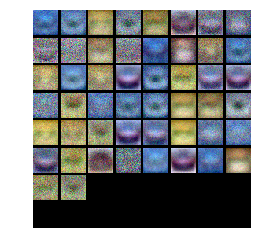

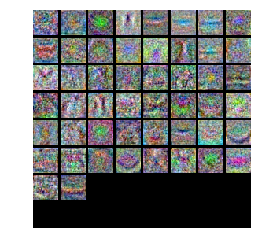

In [229]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.T.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(subopt_net)
show_net_weights(best_net)

blue training acc
orange validation acc


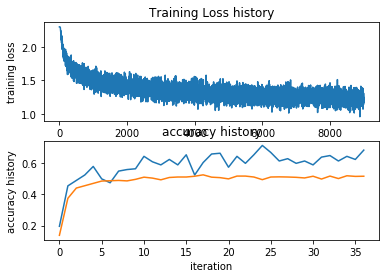

In [230]:

plt.subplot(211)
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')

plt.subplot(212)
plt.plot(stats['train_acc_history'])
plt.plot(stats['val_acc_history'])
plt.xlabel('iteration')
plt.ylabel('accuracy history')
print('blue training acc')
print('orange validation acc')
plt.title('accuracy history')

pass

## Question:

(1) What differences do you see in the weights between the suboptimal net and the best net you arrived at?

## Answer:

(1) The suboptimal net gives results of average car shape. While the best net gives parts, elements of cars. The best one is also more noisy. The noise might make the model more robust to different testing data. 

## Evaluate on test set 

In [231]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.528
